In [1]:
from os.path import join
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import markplotlib

In [3]:
import torch
from torch import nn
from torch import optim

In [4]:
from modules import load_xft
from modules import rank_models

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## config

In [5]:
prodir = join("..", "data", "processed")
cleandir = join("..", "data", "clean")
plotdir = join("..", "plots", "score-modeling")

## load data

In [6]:
emb = load_xft.load_embeddings(join(prodir, "embeddings", "embeddings.json"))
emb = emb.loc[:, "open", :, :]
emb

workoutDescription  \
year workoutNumber                                                      
2011 1              Complete as many rounds and reps as possible i...   
     2              Complete as many rounds and reps as possible i...   
     3              Complete as many rounds and reps as possible i...   
     4              Complete as many rounds and reps as possible i...   
     5              Complete as many rounds and reps as possible i...   
...                                                               ...   
2023 3                          1-rep-max thruster (from the floor)\n   
     4              Starting with a 6-minute time cap, complete as...   
2024 1              21 dumbbell snatches, arm 1\n21 lateral burpee...   
     2              As many rounds and reps as possible in 20 minu...   
     3              All for time:\n\n5 rounds of:\n    10 thruster...   

                           workoutName  \
year workoutNumber                       
2011 1                            11.1   
     2                            11.2   
     3                            11.3   
     4                            11.4   
     5                            11.5   
...                                ...   
2023 3              Open 2023, Event 3   
     4              Open 2023, Event 4   
2024 1              Open 2024, Event 1   
     2              Open 2024, Event 2   
     3              Open 2024, Event 3   

                                                            embedding  \
year workoutNumber                                                      
2011 1              [0.0014607052000000001, -0.0171967745, -0.0041...   
     2              [-0.040680531400000004, -0.0083893705, -0.0010...   
     3              [-0.0295097027, -0.0512414537, -0.0009149106, ...   
     4              [-0.0290717874, -0.0423559062, -0.011125451000...   
     5              [-0.037460614, -0.050566595000000006, -0.00017...   
...                                                               ...   
2023 3              [-0.0395448133, -0.023597907300000002, -0.0096...   
     4              [-0.008133479400000001, -0.0159465708, -0.0106...   
2024 1              [-0.014090227, -0.0338165462, -0.0177209172000...   
     2              [-0.0253820587, -0.0136439158, -0.0046267905, ...   
     3              [-0.0352232717, -0.035956502, -0.0164412875000...   

                            x          y  cluster  
year workoutNumber                                 
2011 1             -30.855844  -7.783034       36  
     2             -15.589044 -10.799054       37  
     3             -14.360186  -5.189207       39  
     4              -9.085351   1.705489       43  
     5             -11.904840  -6.810370       43  
...                       ...        ...      ...  
2023 3             -60.309124   2.127942       40  
     4             -24.362980  -2.763218       39  
2024 1             -28.581274 -22.614759       42  
     2              -5.782496 -21.862415        7  
     3             -17.159681  14.675455       23  

[67 rows x 6 columns]

In [7]:
xft = load_xft.load_competition_results(
    join(cleandir, "competition_results.parquet"), 500
)
xft.head(5)

divisionNumber gender  \
year competitionType workoutNumber divisionName                          
2007 games           1             Men                        1   male   
                                   Men                        1   male   
                                   Men                        1   male   
                                   Men                        1   male   
                                   Men                        1   male   

                                                   height     weight   age  \
year competitionType workoutNumber divisionName                              
2007 games           1             Men           1.680000  70.370071  33.0   
                                   Men           1.770993  81.175217  33.0   
                                   Men           1.653945  64.921913  28.0   
                                   Men           1.791580  87.436272  32.0   
                                   Men           1.832062  84.603508  30.0   

                                                 workoutRank  overallRank  \
year competitionType workoutNumber divisionName                             
2007 games           1             Men                   1.0          2.0   
                                   Men                   2.0          1.0   
                                   Men                   3.0          4.0   
                                   Men                   4.0          3.0   
                                   Men                   5.0          7.0   

                                                        r         o         h  \
year competitionType workoutNumber divisionName                                 
2007 games           1             Men           1.711675  1.359737 -1.679241   
                                   Men           1.359737  1.711675 -0.107399   
                                   Men           1.124338  0.938814 -2.129321   
                                   Men           0.938814  1.124338  0.248230   
                                   Men           0.781034  0.640667  0.947527   

                                                        w         a  
year competitionType workoutNumber divisionName                      
2007 games           1             Men          -2.571880  1.373375  
                                   Men          -0.994818  1.373375  
                                   Men          -3.367064  0.151473  
                                   Men          -0.080987  1.128995  
                                   Men          -0.494442  0.640234

## Simple Multliple Regression

In [8]:
df = xft.xs(key=(2019, "open", 1, "Men"))

In [9]:
X = torch.from_numpy(df[["h", "w", "a"]].values.astype("float32"))
X.shape

torch.Size([473, 3])

In [10]:
y = torch.from_numpy(df["r"].values.astype("float32").reshape(-1, 1))
y.shape

torch.Size([473, 1])

In [11]:
model = rank_models.LinearRegression(X.shape[1])
model.forward(X).shape

torch.Size([473, 1])

In [12]:
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()
var = torch.from_numpy(np.ones((len(y), 1)))
L = []

Text(0.5, 0, 'epoch')

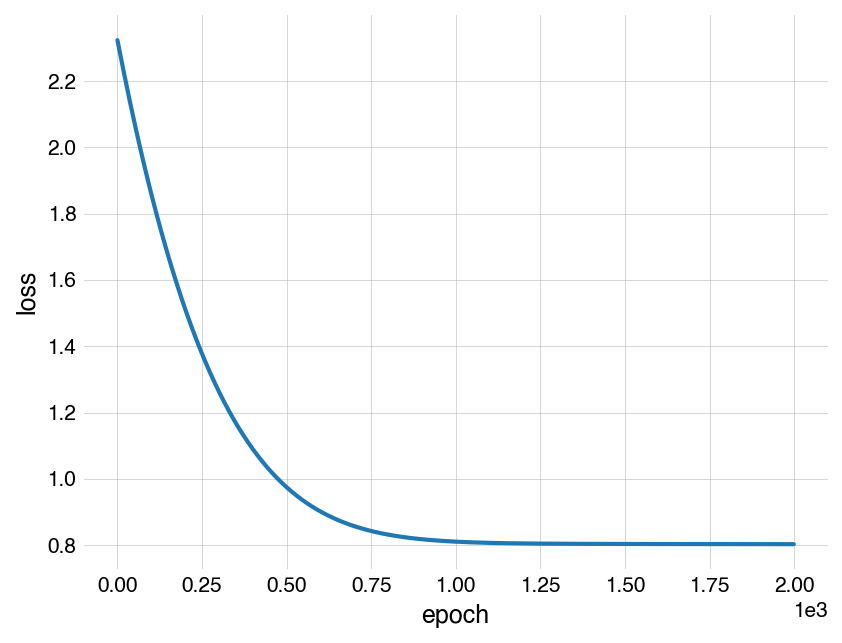

In [13]:
for epoch in range(2000):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    L.append(loss.item())
plt.plot(L)
plt.ylabel("loss")
plt.xlabel("epoch")

In [14]:
pred = model.forward(X).detach().numpy()
targ = y.detach().numpy()

mean residual: -0.00012552208499982953


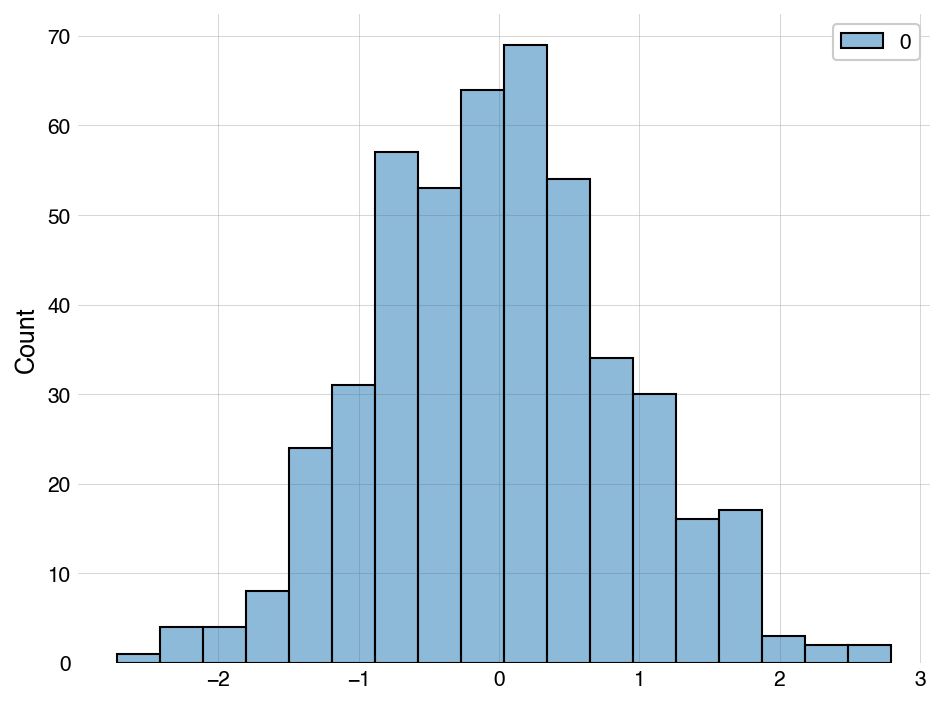

In [15]:
resid = pred - targ
print(f"mean residual: {resid.mean()}")
sns.histplot(resid)
plt.gcf().tight_layout()

In [16]:
model.beta.weight

Parameter containing:
tensor([[ 0.2531,  0.2478, -0.0240]], requires_grad=True)

In [17]:
sm.OLS(y.detach().numpy(), X.detach().numpy()).fit().params

array([ 0.23456791,  0.26849177, -0.02472412], dtype=float32)

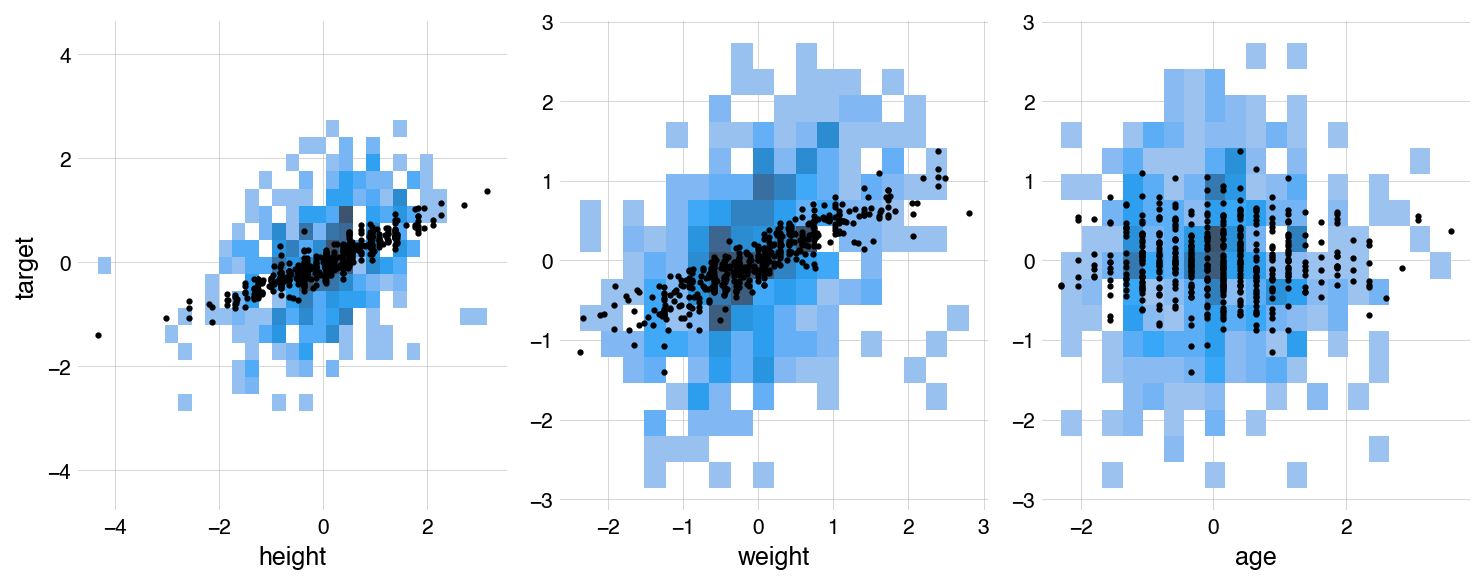

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
for i, x in enumerate(["height", "weight", "age"]):
    sns.histplot(x=X.detach().numpy()[:, i], y=targ.flatten(), ax=axs[i])
    axs[i].scatter(X.detach().numpy()[:, i], pred, c="k", s=4)
    axs[i].set_xlabel(x)
    axs[0].axis("equal")
axs[0].set_ylabel("target")
fig.tight_layout()

## Semantic Model

### some reusable functions for inputs/outputs

In [19]:
def create_inputs_outputs(xft, year, competitionType, workoutNumber, divisionName):
    df = xft.xs(key=(year, competitionType, workoutNumber, divisionName))
    df = df[["h", "w", "a", "r"]].dropna()
    x = df[["h", "w", "a"]].values.astype(np.float32).T
    y = df["r"].values.astype(np.float32)
    return x, y

In [20]:
E = np.stack(emb.embedding, dtype=np.float32)
nemb = E.shape[1]
E = torch.from_numpy(E)
E.shape

torch.Size([67, 3072])

### test model with a single division, intentionally overfitting

In [21]:
X = []
Y = []
for idx in emb.index:
    year, workoutNumber = idx
    # THIS IS ONLY THE MENS DIVISION (to test it)
    x, y = create_inputs_outputs(xft, year, "open", workoutNumber, "Men")
    X.append([torch.from_numpy(x)])
    Y.append([torch.from_numpy(y)])

embedding length = 3072
model parameters = 99491
step 100
  train loss = 0.7596339285373688
step 200
  train loss = 0.7587229236960411
step 300
  train loss = 0.758590504527092
step 400
  train loss = 0.7585608884692192
step 500
  train loss = 0.7585471644997597


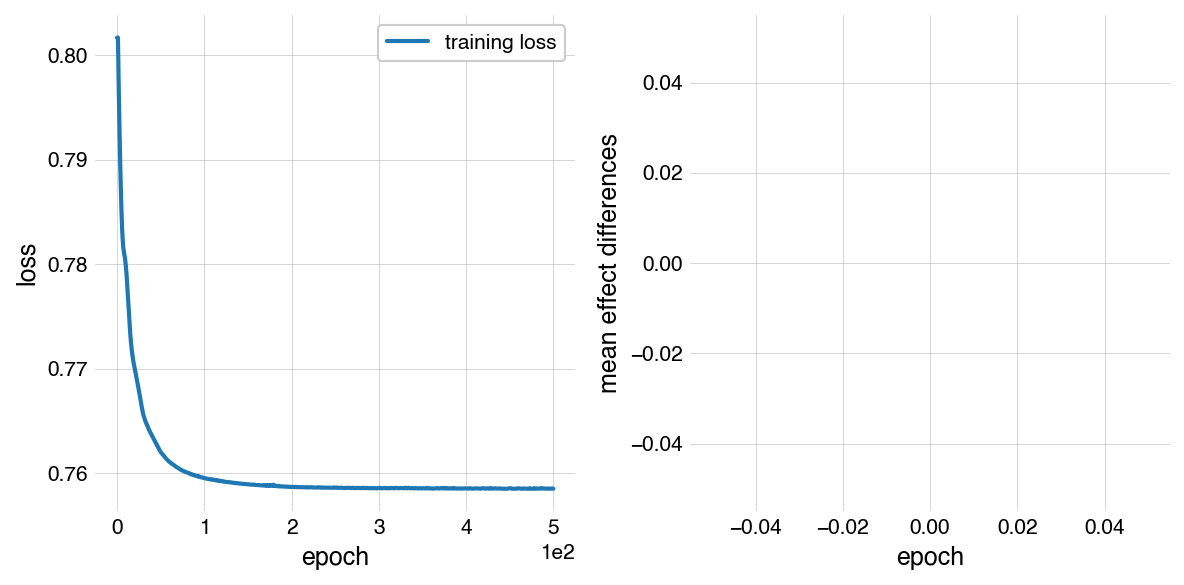

In [22]:
model, criterion, loss, _, _ = rank_models.fit_semantic_model(
    nemb, E, X, Y, nhidden=32, nlayer=2, noise=0.001, epochs=500, plot=True
)

In [23]:
effects = rank_models.semantic_effects(model, E)

In [24]:
regs = rank_models.direct_regressions(X, Y)
regs = np.stack([reg[0] for reg in regs])

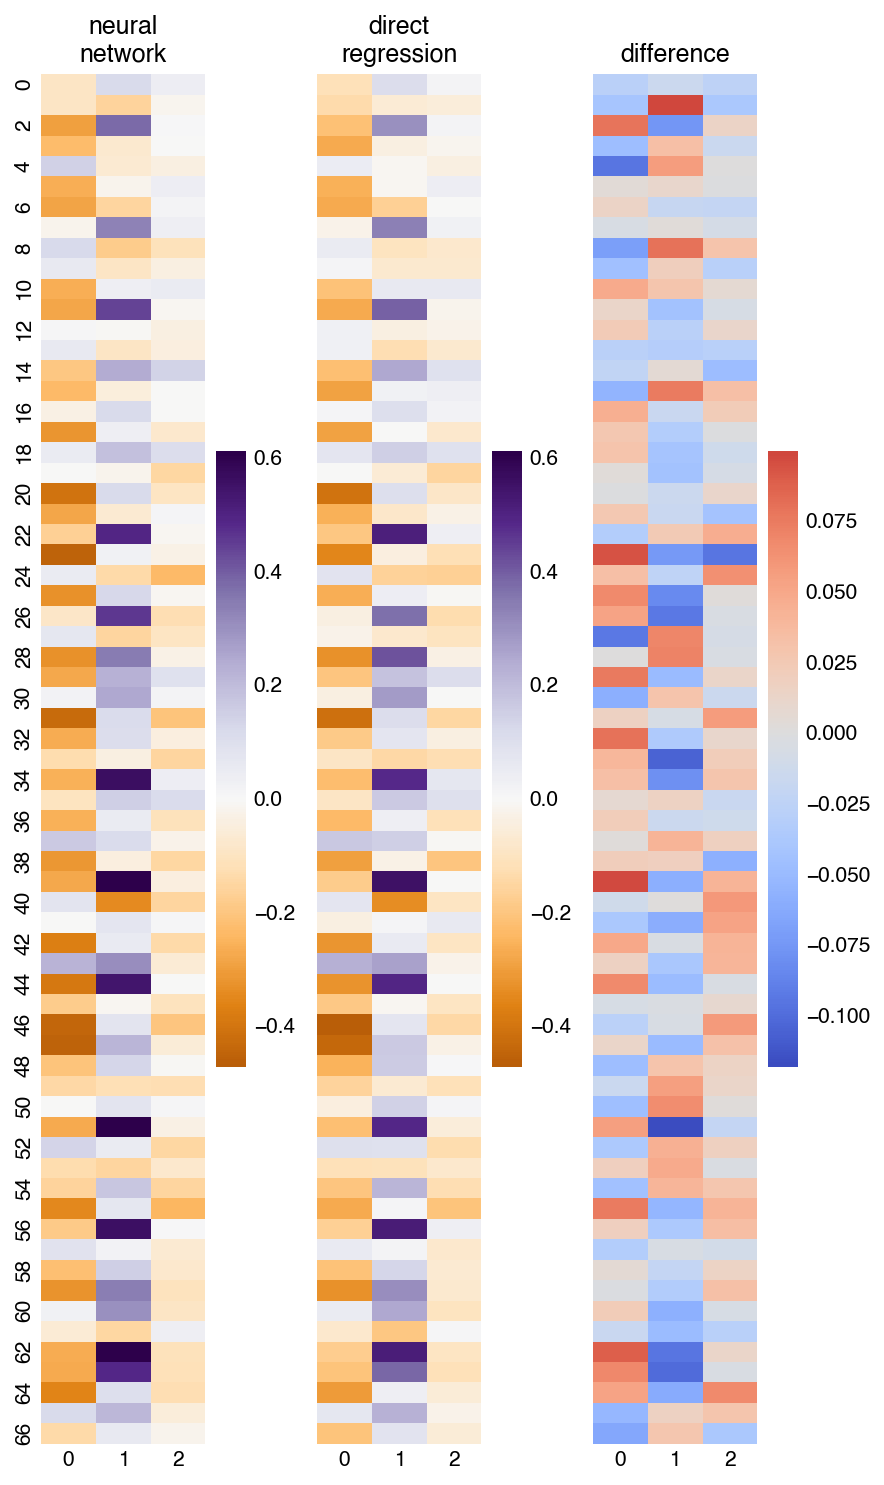

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(6, 10), sharey=True)
vmin = min(effects.min(), regs.min())
vmax = max(effects.max(), regs.max())
sns.heatmap(
    effects,
    center=0,
    ax=axs[0],
    cmap="PuOr",
    vmax=vmax,
    vmin=vmin,
)
axs[0].set_title("neural\nnetwork")
sns.heatmap(
    regs,
    center=0,
    ax=axs[1],
    cmap="PuOr",
    vmax=vmax,
    vmin=vmin,
)
axs[1].set_title("direct\nregression")
sns.heatmap(regs - effects, center=0, cmap="coolwarm", ax=axs[2])
axs[2].set_title("difference")
fig.tight_layout()

## All divisions for all workouts

In [26]:
X = []
Y = []
for idx in emb.index:
    X.append([])
    Y.append([])
    for k, g in xft.xs(key=(idx[0], "open", idx[1])).groupby(level=0):
        x, y = create_inputs_outputs(xft, idx[0], "open", idx[1], k)
        X[-1].append(torch.from_numpy(x))
        Y[-1].append(torch.from_numpy(y))
X = np.array(X, dtype=np.object_)
Y = np.array(Y, dtype=np.object_)

In [27]:
def random_split_indices(N, f):
    idx = np.arange(N)
    np.random.shuffle(idx)
    idx_train = idx[: int(N * (1 - f))]
    idx_test = idx[int(N * (1 - f)) :]
    return idx_train, idx_test

7 validation events
embedding length = 3072
model parameters = 49763
step 100
  train loss = 0.7863663285970688
  valid loss = 0.7805989608168602
  mean abs effect difference = 0.1253180354833603
step 200
  train loss = 0.7836392596364021
  valid loss = 0.7787958234548569
  mean abs effect difference = 0.12632477283477783
step 300
  train loss = 0.7827497273683548
  valid loss = 0.7774659693241119
  mean abs effect difference = 0.12322989851236343


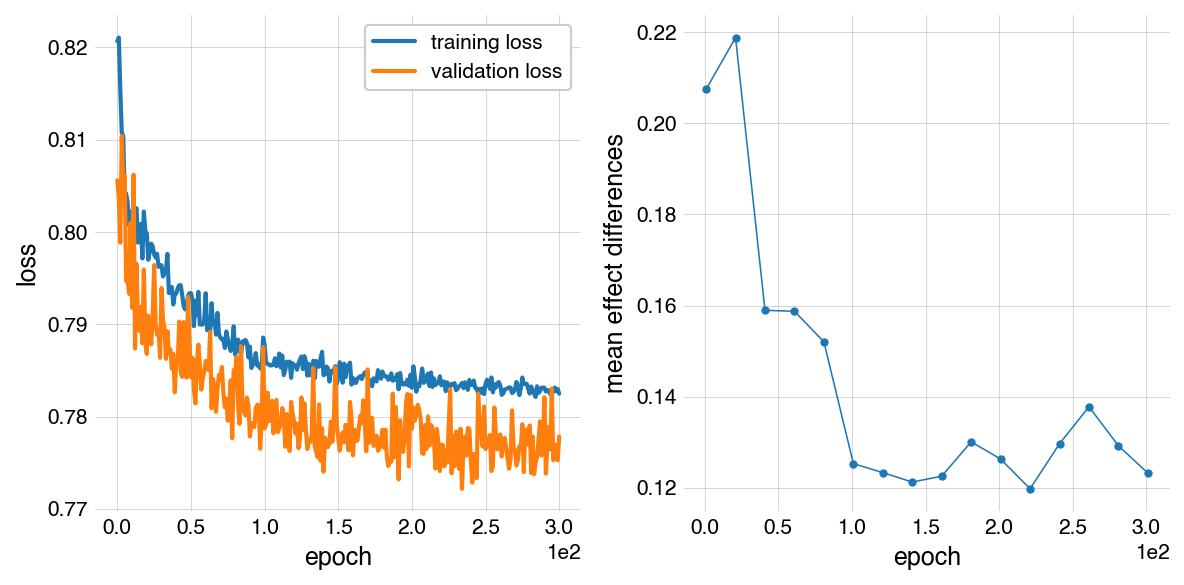

In [28]:
idx_train = np.arange(0, E.shape[0] - 7)
idx_valid = np.arange(E.shape[0] - 7, E.shape[0])
print(f"{len(idx_valid)} validation events")
model, criterion, loss, _, _ = rank_models.fit_semantic_model(
    nemb,
    E[idx_train, :],
    X[idx_train],
    Y[idx_train],
    E[idx_valid, :],
    X[idx_valid],
    Y[idx_valid],
    nlayer=3,
    nhidden=16,
    noise=0.05,
    dropout=0.1,
    epochs=300,
    weight_decay=1e-5,
    plot=True,
)

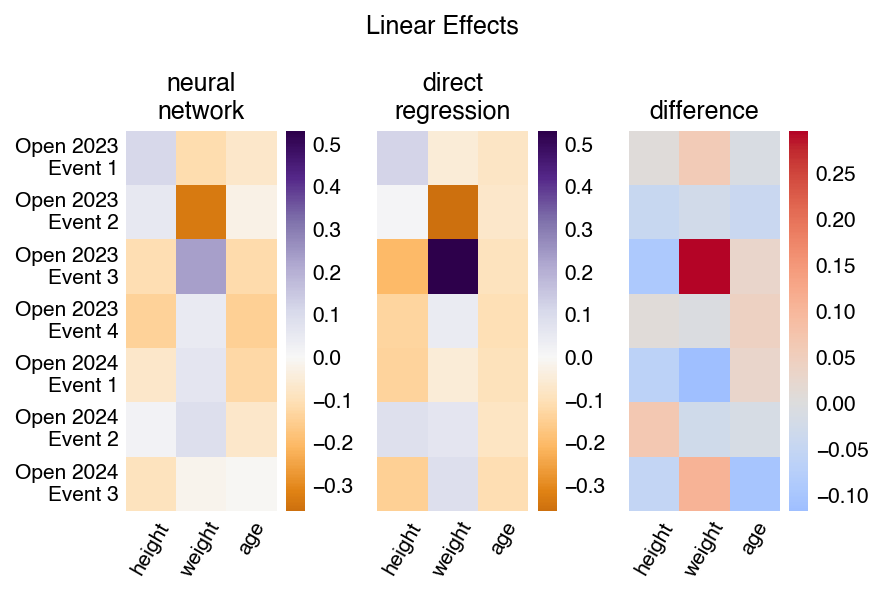

In [29]:
effects = rank_models.semantic_effects(model, E[idx_valid, :])
regs = rank_models.direct_regressions(X[idx_valid], Y[idx_valid])
regs = np.stack([np.stack(reg).mean(axis=0) for reg in regs])
fig, axs = plt.subplots(1, 3, figsize=(6, 4), sharey=True, sharex=True)
vmin = min(effects.min(), regs.min())
vmax = max(effects.max(), regs.max())
sns.heatmap(
    effects,
    center=0,
    ax=axs[0],
    cmap="PuOr",
    vmax=vmax,
    vmin=vmin,
)
axs[0].set_title("neural\nnetwork")
sns.heatmap(
    regs,
    center=0,
    ax=axs[1],
    cmap="PuOr",
    vmax=vmax,
    vmin=vmin,
)
axs[1].set_title("direct\nregression")
sns.heatmap(regs - effects, center=0, cmap="coolwarm", ax=axs[2])
axs[2].set_title("difference")
axs[0].set_yticklabels(
    emb["workoutName"].iloc[-7:].str.replace(", ", "\n").values, rotation=0
)
for ax in axs:
    ax.set_xticklabels(["height", "weight", "age"], rotation=60, ha="center")
fig.suptitle("Linear Effects")
fig.tight_layout()

## Cross validation

In [30]:
years = emb.index.get_level_values(0).values
idxs = {}
for year in emb.index.levels[0]:
    b = year == years
    if np.any(b):
        idxs[year] = np.where(b)[0]
idxs

{2011: array([0, 1, 2, 3, 4, 5]),
 2012: array([ 6,  7,  8,  9, 10]),
 2013: array([11, 12, 13, 14, 15]),
 2014: array([16, 17, 18, 19, 20]),
 2015: array([21, 22, 23, 24, 25, 26]),
 2016: array([27, 28, 29, 30, 31]),
 2017: array([32, 33, 34, 35, 36]),
 2018: array([37, 38, 39, 40, 41, 42]),
 2019: array([43, 44, 45, 46, 47]),
 2020: array([48, 49, 50, 51, 52]),
 2021: array([53, 54, 55, 56]),
 2022: array([57, 58, 59]),
 2023: array([60, 61, 62, 63]),
 2024: array([64, 65, 66])}

In [31]:
def cross_validation(idxs, nhidden, nlayer):
    print(
        f"cross validating with {nhidden} hidden dimensions and {nlayer} hidden layer(s)"
    )
    eff_diffs = []
    for year in idxs:
        idx_valid = idxs[year]
        idx_train = np.sort(list(set(np.arange(E.shape[0])) - set(idx_valid)))
        _, _, _, _, eff_diff = rank_models.fit_semantic_model(
            nemb,
            E[idx_train, :],
            X[idx_train],
            Y[idx_train],
            E[idx_valid, :],
            X[idx_valid],
            Y[idx_valid],
            nlayer=nlayer,
            nhidden=nhidden,
            noise=0.05,
            dropout=0.2,
            epochs=200,
            weight_decay=1e-5,
            plot=False,
            verbose=False,
        )
        eff_diffs.append(eff_diff[-4:].mean())
    return np.mean(eff_diffs)

In [32]:
cross_validation(idxs, None, 0)

cross validating with None hidden dimensions and 0 hidden layers


0.12781455

In [33]:
nhidden = np.array([8, 16, 32, 64, 128])
nlayer = np.array([1, 2, 3])
mean_eff_diff = np.zeros((len(nhidden), len(nlayer)))
for i in range(len(nhidden)):
    for j in range(len(nlayer)):
        mean_eff_diff[i, j] = cross_validation(idxs, nhidden[i], nlayer[j])
        print(nhidden[i], nlayer[j], mean_eff_diff[i, j])

cross validating with 8 hidden dimensions and 1 hidden layers
8 1 0.1365344226360321
cross validating with 8 hidden dimensions and 2 hidden layers
8 2 0.1397933065891266
cross validating with 8 hidden dimensions and 3 hidden layers
8 3 0.14609582722187042
cross validating with 16 hidden dimensions and 1 hidden layers
16 1 0.13250797986984253
cross validating with 16 hidden dimensions and 2 hidden layers
16 2 0.1312425136566162
cross validating with 16 hidden dimensions and 3 hidden layers
16 3 0.13743072748184204
cross validating with 32 hidden dimensions and 1 hidden layers
32 1 0.12977094948291779
cross validating with 32 hidden dimensions and 2 hidden layers
32 2 0.13248620927333832
cross validating with 32 hidden dimensions and 3 hidden layers
32 3 0.1348806917667389
cross validating with 64 hidden dimensions and 1 hidden layers
64 1 0.1279114931821823
cross validating with 64 hidden dimensions and 2 hidden layers
64 2 0.13100261986255646
cross validating with 64 hidden dimensions 

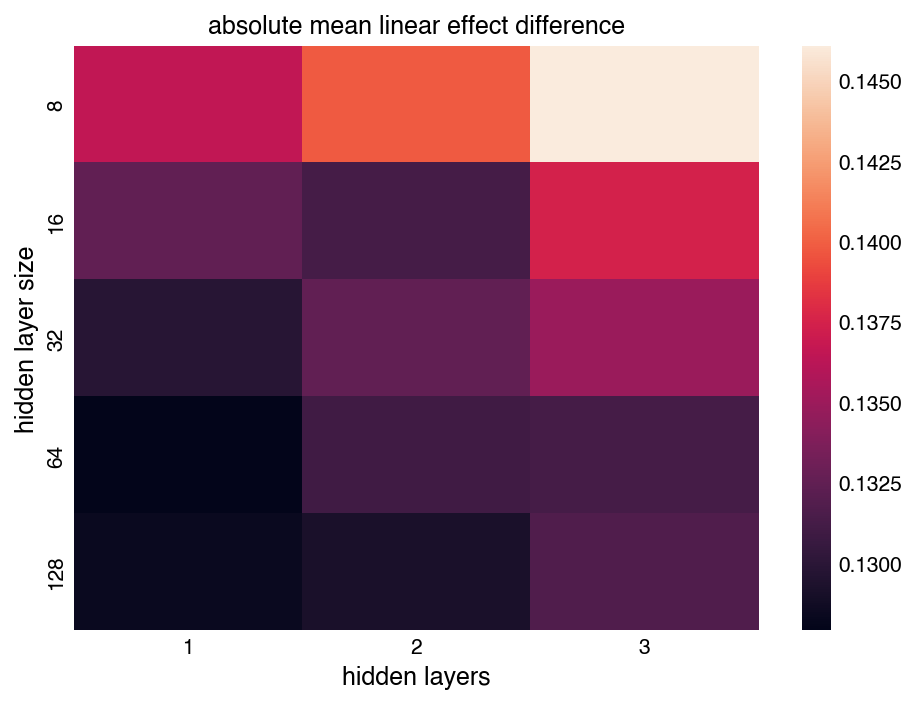

In [38]:
fig, ax = plt.subplots()
sns.heatmap(
    data=mean_eff_diff,
    xticklabels=nlayer,
    yticklabels=nhidden,
    ax=ax,
)
ax.set_xlabel("hidden layers")
ax.set_ylabel("hidden layer size")
ax.set_title("absolute mean linear effect difference")
fig.tight_layout()